# Dask DataFrame (2)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Макрушин С.В. Лекция "Dask DataFrame"
* https://docs.dask.org/en/latest/dataframe.html
* Jesse C. Daniel. Data Science with Python and Dask. 

* https://docs.dask.org/en/stable/generated/dask.dataframe.groupby.DataFrameGroupBy.apply.html
* https://docs.dask.org/en/stable/generated/dask.dataframe.Series.map_overlap.html#dask.dataframe.Series.map_overlap
* https://docs.dask.org/en/stable/_modules/dask/dataframe/rolling.html#Rolling.apply
* https://dask-sql.readthedocs.io/en/latest/quickstart.html

## Задачи для совместного разбора

1. Загрузите данные о пользователях из архива каталога users. Посчитайте средний возраст каждого представленного пола.

In [1]:
import dask.dataframe as dd

In [5]:
df = dd.read_csv('users/*.csv')
df.head(3)

,id,name,age,gender
0,0,GBWAKSZR,57,female
1,1,JZFLVFWE,71,female
2,2,FVKATMOC,65,female


In [4]:
df.groupby('gender')['age'].mean().compute()

gender
female    48.303251
male      48.155142
Name: age, dtype: float64

In [6]:
df.groupby('gender') #apply, transform

2. Создайте bag на основе данных из файла users.txt. Преобразуйте его в dataframe и объедините с фреймом из задачи 1. 


In [7]:
import dask.bag as db

In [12]:
bag = db.read_text('users.txt').repartition(4)
bag.take(2)

('uid:0 street_number:253 street_name:smalfbhbmq city:druxufva state:QU zip_code:12277\n',
 'uid:1 street_number:591 street_name:xduktcwwbn city:rnbfaehq state:KT zip_code:44340\n')

In [15]:
dict([[1,2], [3,4]])

{1: 2, 3: 4}

In [16]:
def f(row):
    kv = row.strip().split()
    r = []
    for el in kv:
        r.append(el.split(':'))
    r = dict(r)
    r['uid'] = int(r['uid'])
    return r

bag = db.read_text('users.txt').repartition(4).map(f)
bag.take(2)

({'uid': 0,
  'street_number': '253',
  'street_name': 'smalfbhbmq',
  'city': 'druxufva',
  'state': 'QU',
  'zip_code': '12277'},
 {'uid': 1,
  'street_number': '591',
  'street_name': 'xduktcwwbn',
  'city': 'rnbfaehq',
  'state': 'KT',
  'zip_code': '44340'})

In [18]:
df2 = bag.to_dataframe()
df2.head()

,uid,street_number,street_name,city,state,zip_code
0,0,253,smalfbhbmq,druxufva,QU,12277
1,1,591,xduktcwwbn,rnbfaehq,KT,44340
2,2,660,omggxsgdnb,rchrmqzu,SE,80696
3,3,810,jmpllqdjmy,boujamgy,QR,45706
4,4,344,iwzdcewpnq,rjjuktgk,QO,78134


In [19]:
df.merge(df2, left_on="id", right_on="uid").head(2)

,id,name,age,gender,uid,street_number,street_name,city,state,zip_code
0,2500,ZNOXHMSI,35,male,2500,631,lbxyjvwiur,ybogayph,PA,29890
1,2502,BWGBPUHI,51,male,2502,691,kvrhycoxrp,hivflnka,JR,85055


3. Вычислите произведение каждой пары последовательно идущих возрастов людей.

In [20]:
df['age'].head(3)

0    57
1    71
2    65
Name: age, dtype: int64

In [23]:
df['age'].rolling(window=2).mean().head(4)

0     NaN
1    64.0
2    68.0
3    67.5
Name: age, dtype: float64

In [24]:
def prod(s):
    return s.prod()

df['age'].rolling(window=2).apply(prod, raw=False).head()

0       NaN
1    4047.0
2    4615.0
3    4550.0
4    5320.0
Name: age, dtype: float64

4. Используя dask_sql, найдите топ-5 возрастов, имеющих наибольшее кол-во представителей.

In [30]:
#!pip install dask_sql

In [32]:
#!pip install threadpoolctl==3.1.0

In [33]:
import dask_sql
from dask_sql import Context

In [34]:
c = Context()

In [35]:
c.create_table("users", df)

In [38]:
c.sql('''
SELECT * 
FROM users
''').head()

,id,name,age,gender
0,0,GBWAKSZR,57,female
1,1,JZFLVFWE,71,female
2,2,FVKATMOC,65,female
3,3,IIJOOMKY,70,male
4,4,IEBIJZHJ,76,male


In [39]:
c.sql('''
SELECT DISTINCT(Age), COUNT(Age) AS sm
FROM users
GROUP BY Age
ORDER BY sm DESC
LIMIT 5
''').head()

,age,sm
28,55,192
24,42,186
17,25,180
2,65,180
44,38,179


5. Создайте функцию rename_gender и сделайте выборку из таблицы с ее использованием при помощи dask_sql

In [40]:
def rename_gender(genders):
    return genders.map({"female":"ж", "male":"м"})

c.register_function(
    rename_gender,
    "ren",
    [("genders", str)],
    str
)

In [42]:
c.sql("""
SELECT *, ren(gender) as renamed
FROM users
""").head()

,id,name,age,gender,renamed
0,0,GBWAKSZR,57,female,ж
1,1,JZFLVFWE,71,female,ж
2,2,FVKATMOC,65,female,ж
3,3,IIJOOMKY,70,male,м
4,4,IEBIJZHJ,76,male,м


## Лабораторная работа 13

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений проводятся над `dask.DataFrame` и средствами пакета `dask`, если в задании не сказано обратного. Переход от коллекций `dask` возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.DataFrame` (то есть то, что было получено до вызова `compute`, а не после).

In [1]:
import dask.dataframe as dd

<p class="task" id="1"></p>

1\. В архиве `recipes_full.zip` находятся файлы, содержащие информацию об рецептах блюд. Загрузите данные из файлов этого архива в виде `dd.DataFrame` с названием `recipes`. Для каждого автора рассчитайте максимальное количество ингредиентов, которые используются в его рецептах.

In [2]:
recipes = dd.read_csv('recipes_full/recipes_full_*.csv', assume_missing=True, parse_dates=['submitted'])
recipes.head(3)

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
0,683970.0,vant ivoire mickies nothing,33.0,803776.0,2019-08-22,4.0,pat and gina neely and their family own and op...,9.0
1,1089012.0,kremsils mariposa baccala cookies class borage...,23.0,51579.0,2013-03-02,1.0,"a light, tasty and easy to put together chicke...",5.0
2,1428572.0,tania lander,0.0,68884.0,1980-11-09,1.0,a delicious melt in your mouth appetizer. for ...,5.0


In [15]:
recipes.groupby('id')['n_ingredients'].max().compute()

id
40.0          6.0
45.0          9.0
81.0          5.0
153.0        12.0
174.0         8.0
             ... 
2231582.0     1.0
2231605.0     6.0
2231607.0     7.0
2231616.0     3.0
2231625.0     4.0
Name: n_ingredients, Length: 2128101, dtype: float64

<p class="task" id="2"></p>

2\. Удалите строки, которые содержат пропуске в столбце `contributor_id` и приведите его тип к целочисленному. Для каждого `contributor_id` найдите топ-5 слов, которых этот пользователь наиболее часто использовал в названиях своих рецептов. Для разбиения на слова воспользуйтесь методом `.str.split`.

Выведите на экран статистику для пользователя с ID 1530.

In [3]:
recipes = recipes.dropna(subset=['contributor_id'])
recipes['contributor_id'] = recipes['contributor_id'].astype(int)

In [24]:
def f(ser):
    ser = ''.join
    return ser
recipes.groupby('contributor_id')['name'].apply(f, meta={'name':str}).head()

9                                      [tuna, fritters]
9                                       [wafers, wight]
12    [itches, rasberry, swai, kroketten, huzarensla...
14    [hooper, riz, tamales, bek, appleade, burritos...
14                                                 [li]
Name: name, dtype: object

In [61]:
def word_count(cont_id):
    rec = recipes[recipes['contributor_id'] == cont_id]
    return (cont_id, rec["name"].str.split().to_bag().flatten().frequencies().topk(5, key=lambda x: x[1]))

In [62]:
words = recipes['contributor_id'].to_bag().distinct()
words

dask.bag<distinct-aggregate, npartitions=1>

In [64]:
res = words.map(word_count)
res = res.filter(lambda x: x[0] == 1530).compute()[0]
res

(1530, dask.bag<topk-aggregate, npartitions=1>)

In [65]:
res[0], res[1].compute()

(1530,
 [('chocolate', 7), ('muffins', 6), ('bread', 5), ('and', 4), ('whole', 3)])

<p class="task" id="3"></p>

3\. В архиве `stats.zip` находятся файлы, содержащие статистику по рецептам. Загрузите данные из файлов этого архива в виде `dd.DataFrame` с названием `stats`. Объедините две таблицы `recipes` и `stats`. Для каждого рецепта посчитайте среднее количество лайков за период, начиная с даты публикации рецепта и до 1 апреля 2023 года (включительно). Выведите на экран информацию о рецепте, имеющем максимальное значение этой величины.

In [4]:
stats = dd.read_csv('stats/stats_*.csv', assume_missing=True)
stats.head()

,recipe_id,views,likes,verified
0,1979735,3331.0,552.0,False
1,283100,2168.0,2699.0,False
2,52604,2378.0,8444.0,False
3,1968356,3543.0,3097.0,True
4,1054c1,3164.0,4782.0,True


In [5]:
recipes['id'] = recipes['id'].astype(int).astype(str)
stats['recipe_id'] = stats['recipe_id'].astype(str)
merged = recipes.merge(stats, left_on="id", right_on="recipe_id")

In [56]:
res = merged[merged['submitted']<='2023-04-01'].groupby('id')['likes'].sum()
res.max().compute()

56748.0

In [6]:
merged['mean_likes'] = merged['likes'] / (datetime.datetime(2023, 4, 2) - merged['submitted']).dt.days  

merged[merged['mean_likes'] == merged['mean_likes'].max()]

<p class="task" id="4"></p>

4\. Используя `dask_sql`, выберите из таблицы `recipes` id, название и описание тех рецептов, которые были добавлены в 2010 году. Выведите полученный результат на экран в виде `pd.DataFrame`. Выведите на экран количество  рецептов, которые были добавлены в 2010 году.

In [10]:
import dask_sql
from dask_sql import Context

In [ ]:
recipes['n_ingredients']

In [11]:
c = Context()
c.create_table("Recipe", recipes)

In [64]:
answer = c.sql('''
SELECT id, name, description
FROM Recipe
WHERE YEAR(submitted) = 2010
''')
answer.head(npartitions=-1)

,id,name
8,818815,beirox dalmation gittle rougeux
379,380095,shabbos sourest includes chevops schelvisch en...
381,1006702,stitch frisch roses oranged levana
388,1519209,gingernuts anconetana reuben
407,438167,deep chocolate pistachio brownies


In [65]:
len(answer)

50839

<p class="task" id="5"></p>

5\. Создайте функцию `get_recipe_types`, которая определяет сложность рецепта по следующему правилу: если кол-во ингредиентов не больше 5, то рецепт простой ("easy"); если не кол-во ингредиентов не больше 15, то рецепт средней сложности ("medium"); иначе рецепт является сложным ("hard"). 

```python
def get_type(ingredients: int) -> str:
    pass
```

Зарегистрируйте эту функцию для применения в SQL-запросе.

In [12]:
def get_type(ingredients: int) -> str:
    def pr(num):
        if num <= 5.0:
            return "easy"
        if 5 < num <= 15.0:
            return "medium"
        else:
            return "hard"
    return ingredients.map(pr)

In [13]:
c.register_function(
    get_type,
    "get_type",
    [("ingredients", float)],
    str
)

<p class="task" id="6"></p>

6\. Используя `dask_sql`, посчитайте количество рецептов с группировкой по их типу (простой, средний или сложный). Для определения типа рецепта в SQL-запросе воспользуйтесь функцией, зарегистрированной в предыдущем задании. Выведите на экран в виде серии с индексами "easy", "medium" и "hard". 

In [39]:
ans = c.sql("""
SELECT COUNT(id) as counted_id, type FROM
    (SELECT id, get_type(n_ingredients) as type FROM Recipe) 
    GROUP BY type
""").compute()

In [50]:
ans.set_index('type')

,counted_id
type,
medium,1067731
easy,1151285
hard,12621


<p class="task" id="7"></p>

7\. Используя `dask_sql`, объедините таблицы и посчитайте и выведите на экран, сколько рецептов являются верифицированными и не верифицированными. Если информация о верификации рецепта отсутствует, то считайте его не верифицированным. Вся логика подсчета значений должна быть реализована в виде запроса на языке SQL.

In [53]:
c.create_table("Stat", stats)

In [60]:
c.sql("""
SELECT COUNT(*) as count_verified
FROM Recipe
JOIN Stat ON Stat.recipe_id = Recipe.id
WHERE Stat.verified = 1
""").compute()

,count_verified
0,443936


<p class="task" id="8"></p>

8\. В файлах архива `site_logs.zip` находятся логи системы. Считайте эти логи в виде `dask.bag`, выделите их них дату, время, id службы, уровень лога и сообщение. Объедините дату и время в одну строку в формате "ГГГГММДД ЧЧММСС". В итоге каждый элемент `Bag` должен представлять собой словарь с ключами `datetime`, `service_id`, `msg`, `level`.

Преобразуйте `dask.bag` в `dask.dataframe`, предварительно оставив только логи уровня "INFO". Подтвердите корректность решения, выведя на экран уникальные значения столбца `level` полученной таблицы.

```
date(ymd)   time(HMS)   service_id level   msg
081110      103041      34         INFO    dfs.FSNamesystem: BLOCK* NameSystem.delete: ...
```

In [2]:
import dask.bag as db

In [3]:
bag = db.read_text('site_logs/logs_*')
bag.take(5)

('081109 203518 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010\n',
 '081109 203518 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906\n',
 '081109 203519 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010\n',
 '081109 203519 145 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.14.224:42420 dest: /10.250.14.224:50010\n',
 '081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_-1608999687919862906 terminating\n')

In [4]:
def f8(line):
    line = line.strip().split()
    date = '20' + line[0] + ' ' + line[1]
    msg = ''.join(line[3:])
    return dict(zip(['datetime', 'service_id', 'level', 'msg'],[date, line[2], line[3], msg]))

In [5]:
bag = bag.map(f8)
bag.take(1)

({'datetime': '20081109 203518',
  'service_id': '143',
  'level': 'INFO',
  'msg': 'INFOdfs.DataNode$DataXceiver:Receivingblockblk_-1608999687919862906src:/10.250.19.102:54106dest:/10.250.19.102:50010'},)

In [6]:
df = bag.filter(
    lambda x: x['level']=='INFO'
).to_dataframe(
    meta={'datetime':str, 'service_id':str, 'level':str, 'msg':str}
)
df.head(npartitions=-1)

,datetime,service_id,level,msg
0,20081109 203518,143,INFO,INFOdfs.DataNode$DataXceiver:Receivingblockblk...
1,20081109 203518,35,INFO,INFOdfs.FSNamesystem:BLOCK*NameSystem.allocate...
2,20081109 203519,143,INFO,INFOdfs.DataNode$DataXceiver:Receivingblockblk...
3,20081109 203519,145,INFO,INFOdfs.DataNode$DataXceiver:Receivingblockblk...
4,20081109 203519,145,INFO,INFOdfs.DataNode$PacketResponder:PacketRespond...


In [10]:
df['level'].unique().compute()

0    INFO
Name: level, dtype: object

<p class="task" id="9"></p>

9\. Добавьте в таблицу из предыдущего задания столбец `is_delete_op`, который содержит флаг: является ли данная операция удалением чего-либо или нет. Для выяснения этого факта проанализизируйте сообщение лога. 

Для каждого лога подсчитайте, сколько из записанных перед ним последних 100 логов являются операциями удаления. Для вычислений используйте метод `map_overlap`. Посчитайте и выведите на экран, сколько существует подпоследовательностей длины 100, состоящих не менее чем из 75 сообщений, содержащих операции удаления.

In [7]:
df['is_delete_op'] = df['msg'].str.contains('delete').astype(int)

In [8]:
res = df['is_delete_op'].map_overlap(lambda part: part.rolling(100).sum(), 0, 1)
res[res >= 75].size.compute()

1384650

<p class="task" id="10"></p>

10\. Сгруппируйте таблицу с логами по часу, в котором был оставлен лог. Под часом имеется в виду час конкретного дня, то связь связка год-месяц-день-час.  Посчитайте, сколько логов было записано за каждый час. Визуализируйте полученную динамику. Добавьте подписи засечек, подписи осей и название рисунка.

In [16]:
df['datetime'] = dd.to_datetime(df['datetime'], format='%Y%m%d %H%M%S')
grouped = df.set_index('datetime').resample('H')
counted = grouped.count().compute()

In [38]:
counted.head()

,service_id,level,msg,is_delete_op
datetime,,,,
2008-11-09 20:00:00,188715,188715,188715,188715
2008-11-09 21:00:00,307477,307477,307477,307477
2008-11-09 22:00:00,24344,24344,24344,24344
2008-11-09 23:00:00,267017,267017,267017,267017
2008-11-10 00:00:00,177398,177398,177398,177398


In [18]:
import matplotlib.pyplot as plt

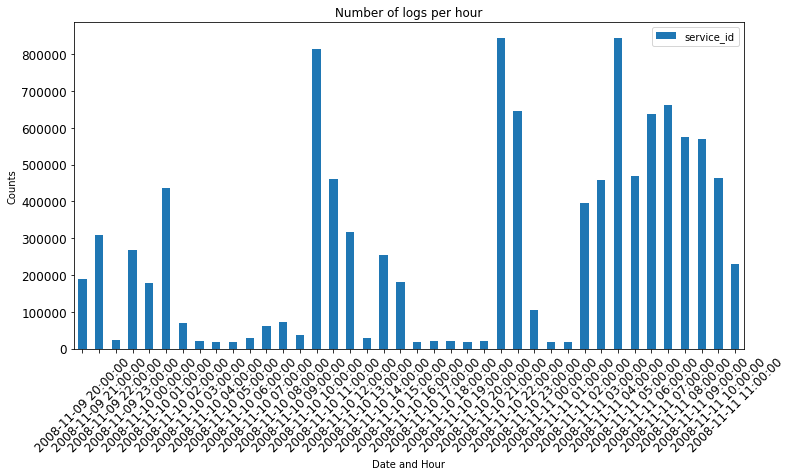

In [37]:
fig, ax = plt.subplots(figsize=(12, 6)) # задаем размер фигуры
counted.plot(kind='bar', y='service_id', ax=ax, fontsize=12)

ax.set_xlabel('Date and Hour')
ax.set_ylabel('Counts')
ax.set_title('Number of logs per hour')
ax.tick_params(axis='x', labelrotation=45)